In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Generate Load Time Series

In [2]:
# Simulated time-series (sine wave + noise)
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = [np.sin(x + np.random.rand()) + 0.1 * np.random.randn(seq_length) for _ in range(num_samples)]
    return np.array(data)

seq_length = 50
num_samples = 1000
real_data = generate_sine_wave(seq_length, num_samples)

# Normalize to range [-1, 1]
real_data = (real_data - real_data.min()) / (real_data.max() - real_data.min())
real_data = 2 * real_data - 1

# Torch tensor
real_data = torch.tensor(real_data, dtype=torch.float32)

# Dataloader
batch_size = 32
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Define Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_length):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, seq_length):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


Training Setup

In [4]:
noise_dim = 16
generator = Generator(noise_dim, seq_length).to(device)
discriminator = Discriminator(seq_length).to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


Training Loop

In [5]:
epochs = 200
for epoch in range(epochs):
    for batch in dataloader:
        real_seq = batch[0].to(device)
        batch_size = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_seq = generator(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = loss_fn(discriminator(real_seq), real_labels)
        d_fake_loss = loss_fn(discriminator(fake_seq.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_loss = loss_fn(discriminator(fake_seq), real_labels)

        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 20, D Loss: 1.2724, G Loss: 0.8187
Epoch 40, D Loss: 1.3970, G Loss: 0.7076
Epoch 60, D Loss: 1.2878, G Loss: 0.7641
Epoch 80, D Loss: 1.3490, G Loss: 0.7274
Epoch 100, D Loss: 1.4377, G Loss: 0.6421
Epoch 120, D Loss: 1.3912, G Loss: 0.7014
Epoch 140, D Loss: 1.3286, G Loss: 0.7354
Epoch 160, D Loss: 1.3680, G Loss: 0.7086
Epoch 180, D Loss: 1.3743, G Loss: 0.6928
Epoch 200, D Loss: 1.3426, G Loss: 0.7369


Visualize generated data

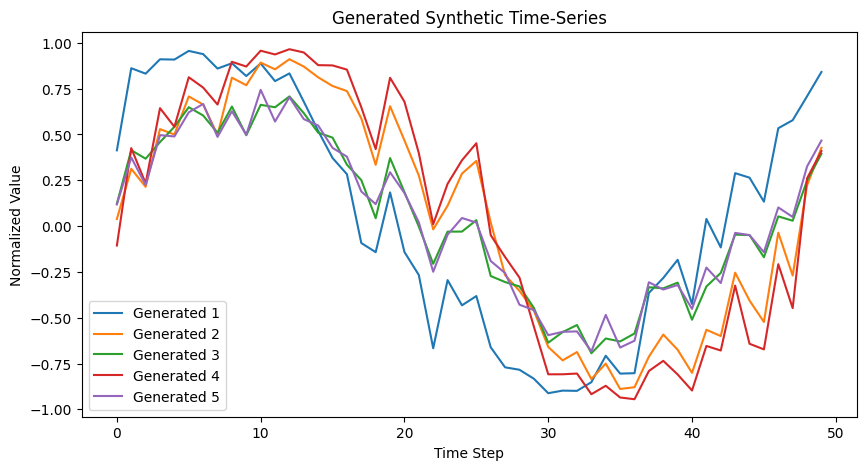

In [7]:
generator.eval()
with torch.no_grad():
    z = torch.randn(5, noise_dim).to(device)
    gen_seq = generator(z).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(gen_seq[i], label=f"Generated {i+1}")
plt.title("Generated Synthetic Time-Series")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


Real example        

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


Load Real Stock Price Data

In [3]:
# Load stock price data from Yahoo Finance
def load_stock_data(ticker="AAPL", start="2022-01-01", end="2022-12-31"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = (prices - np.mean(prices)) / np.std(prices)  # Normalize
    return prices

real_data = load_stock_data()
sequence_length = 30

# Create sequences
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
sequences

array([[[ 2.07316322],
        [ 1.89401463],
        [ 1.52330822],
        ...,
        [ 1.32316654],
        [ 1.05293795],
        [ 1.07157465]],

       [[ 1.89401463],
        [ 1.52330822],
        [ 1.29685505],
        ...,
        [ 1.05293795],
        [ 1.07157465],
        [ 1.37519471]],

       [[ 1.52330822],
        [ 1.29685505],
        [ 1.31003608],
        ...,
        [ 1.07157465],
        [ 1.37519471],
        [ 1.35655439]],

       ...,

       [[-0.47597133],
        [-0.33868488],
        [-0.43618983],
        ...,
        [-1.72792725],
        [-1.75678897],
        [-1.8995335 ]],

       [[-0.33868488],
        [-0.43618983],
        [-0.28564288],
        ...,
        [-1.75678897],
        [-1.8995335 ],
        [-2.21076694]],

       [[-0.43618983],
        [-0.28564288],
        [-0.24117993],
        ...,
        [-1.8995335 ],
        [-2.21076694],
        [-1.93229523]]])

Create GAN (Generator & Discriminator) - Modifying code for WGAN-GP

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_len)
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # No sigmoid here!
        )

    def forward(self, x):
        return self.net(x)


Defining Gradient Penalty

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


Train GAN

In [7]:
# Settings
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 30
batch_size = 32
epochs = 1000

# Prepare data
tensor_data = torch.tensor(sequences, dtype=torch.float32)
loader = DataLoader(TensorDataset(tensor_data), batch_size=batch_size, shuffle=True)

# Models
G = Generator(noise_dim, sequence_length).to(device)
D = Discriminator(sequence_length).to(device)

# Optimizers & loss
# criterion = nn.BCELoss()
# opt_G = torch.optim.Adam(G.parameters(), lr=0.001)
# opt_D = torch.optim.Adam(D.parameters(), lr=0.001)
opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))


# Training loop
# for epoch in range(epochs):
#     for real_batch, in loader:
#         real_batch = real_batch.to(device).view(real_batch.size(0), -1)

#         # Train Discriminator
#         z = torch.randn(real_batch.size(0), noise_dim).to(device)
#         fake_batch = G(z)

#         real_labels = torch.ones(real_batch.size(0), 1).to(device)
#         fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

#         D_real = D(real_batch)
#         D_fake = D(fake_batch.detach())
#         loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

#         opt_D.zero_grad()
#         loss_D.backward()
#         opt_D.step()

#         # Train Generator
#         D_fake = D(fake_batch)
#         loss_G = criterion(D_fake, real_labels)  # Fooling the discriminator

#         opt_G.zero_grad()
#         loss_G.backward()
#         opt_G.step()

#     if (epoch+1) % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



lambda_gp = 10

for epoch in range(epochs):
    for real_batch in loader:
        real = real_batch[0].to(device)
        batch_size = real.size(0)  # Update batch_size dynamically
        real = real.view(batch_size, -1)  # Flatten the input
        batch_size = real.size(0)

        # ======== Train Discriminator ========
        for _ in range(5):  # More D updates per G update
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = G(z).detach()
            d_real = D(real).mean()
            d_fake = D(fake).mean()
            gp = compute_gradient_penalty(D, real.data, fake.data)
            d_loss = -d_real + d_fake + lambda_gp * gp

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # ======== Train Generator ========
        z = torch.randn(batch_size, noise_dim).to(device)
        gen_data = G(z)
        g_loss = -D(gen_data).mean()

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    # Logging (optional)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")



Epoch 0 | D_loss: 4.9678 | G_loss: 0.0413
Epoch 100 | D_loss: -3.4052 | G_loss: -0.5074
Epoch 200 | D_loss: -0.7963 | G_loss: -3.1344
Epoch 300 | D_loss: -0.6122 | G_loss: 0.0083
Epoch 400 | D_loss: -0.2906 | G_loss: 1.2901
Epoch 500 | D_loss: -0.4340 | G_loss: 2.1737
Epoch 600 | D_loss: -0.5702 | G_loss: 3.6084
Epoch 700 | D_loss: -0.9932 | G_loss: 4.7546
Epoch 800 | D_loss: -0.8542 | G_loss: 5.4165
Epoch 900 | D_loss: -0.6527 | G_loss: 6.7341


Plot

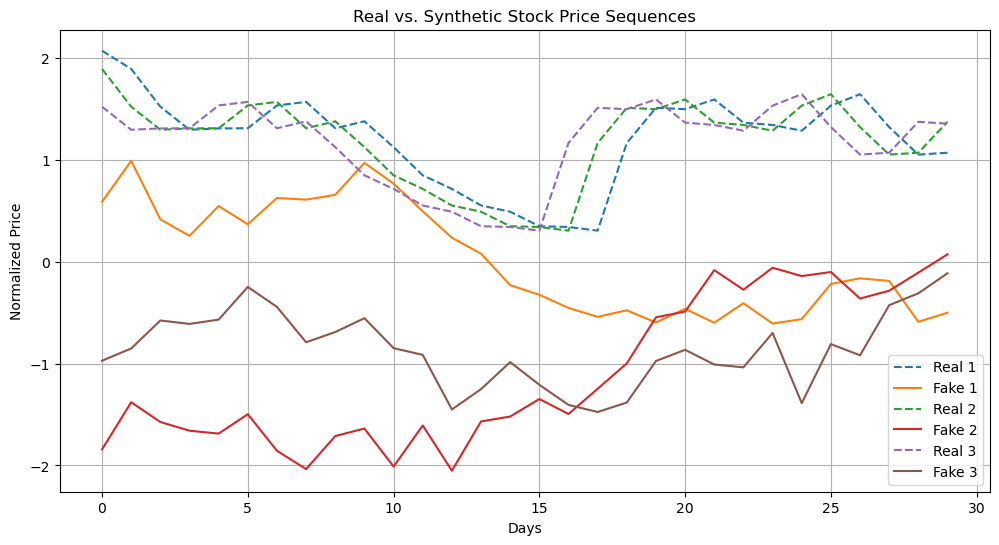

In [8]:
# Generate synthetic sequences
with torch.no_grad():
    z = torch.randn(100, noise_dim).to(device)
    synthetic_sequences = G(z).cpu().numpy()

# Plot a few samples
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sequences[i], label=f"Real {i+1}", linestyle='dashed')
    plt.plot(synthetic_sequences[i], label=f"Fake {i+1}")
plt.legend()
plt.title("Real vs. Synthetic Stock Price Sequences")
plt.xlabel("Days")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()


# **Financial GANs**

##  TimeGAN

[*********************100%***********************]  1 of 1 completed


Epoch 0 | D_loss: 1.3318 | G_loss: 0.6880


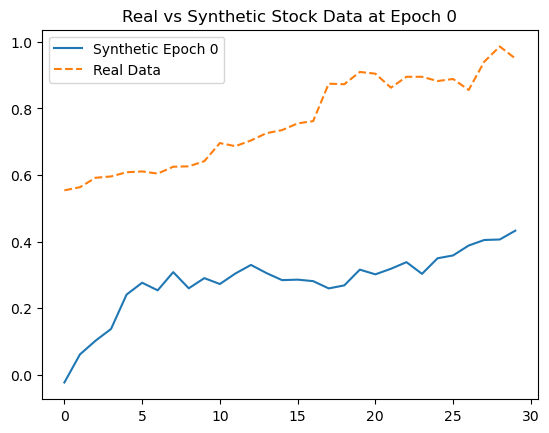

Epoch 100 | D_loss: 1.3892 | G_loss: 0.6948
Epoch 200 | D_loss: 1.3972 | G_loss: 0.7035


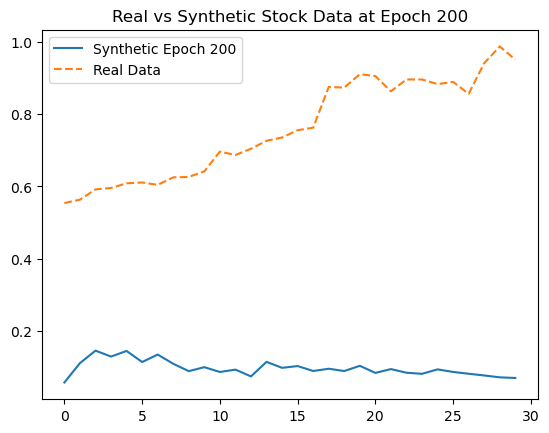

Epoch 300 | D_loss: 1.4033 | G_loss: 0.6933
Epoch 400 | D_loss: 1.3818 | G_loss: 0.6390


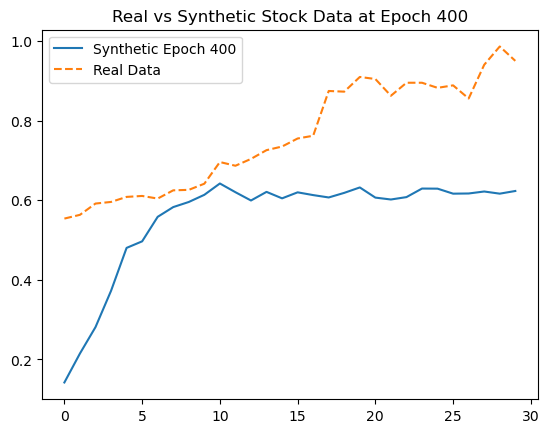

Epoch 500 | D_loss: 1.4240 | G_loss: 0.6810
Epoch 600 | D_loss: 1.4301 | G_loss: 0.7317


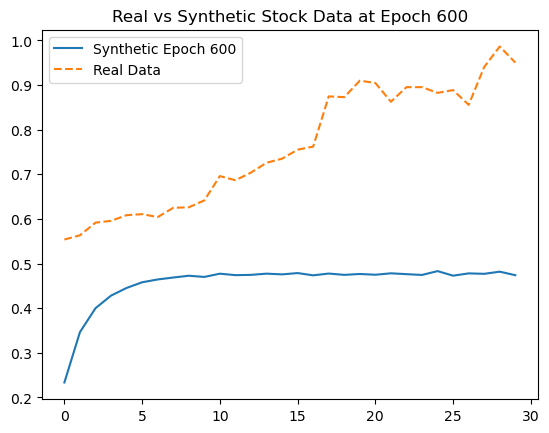

Epoch 700 | D_loss: 1.3457 | G_loss: 0.6713
Epoch 800 | D_loss: 1.4082 | G_loss: 0.6886


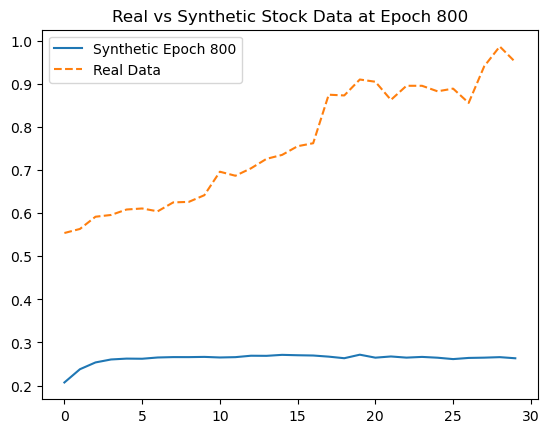

Epoch 900 | D_loss: 1.4200 | G_loss: 0.7041


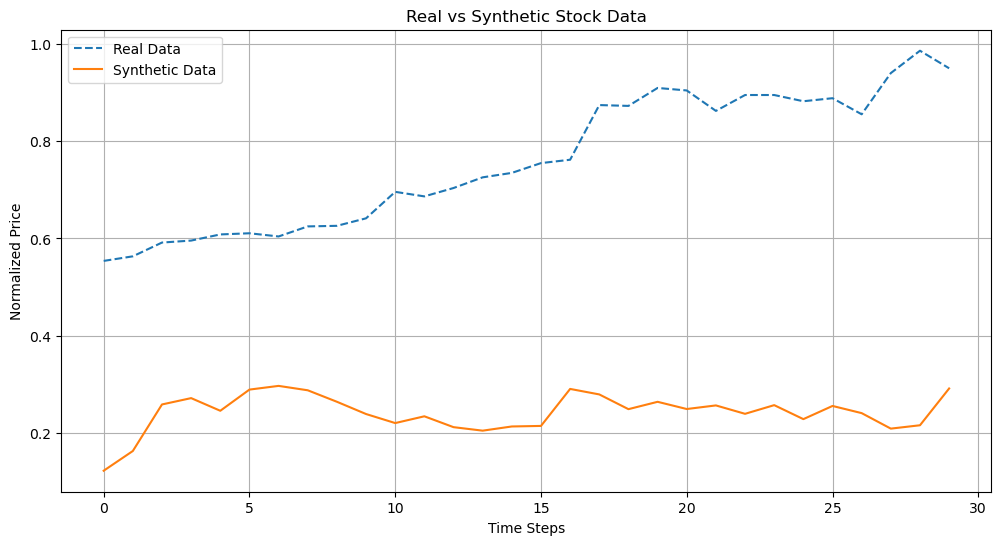

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = prices.reshape(-1, 1)  # Reshape to 2D
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)  # Normalize data
    return scaled_prices

# Load NVIDIA stock data
real_data = load_stock_data()

# Create sequences (example: 30 days of data)
sequence_length = 30
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)
sequences = torch.tensor(sequences, dtype=torch.float32)


# 2. Define Models (Encoder, Recovery, Generator, Discriminator)

# Encoder: LSTM autoencoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, seq_len)

    def forward(self, x):
        h, (hn, cn) = self.lstm(x)
        z = self.fc(hn[-1])
        return z

class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Recovery, self).__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        x_tilde = self.fc(h_out)
        return x_tilde

class Supervisor(nn.Module):
    def __init__(self, hidden_dim):
        super(Supervisor, self).__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, h):
        h_hat, _ = self.lstm(h)
        return h_hat



# Generator: LSTM generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # OUTPUT one value per time step

    def forward(self, z):
        h, _ = self.lstm(z)  # shape: [batch_size, seq_len, hidden_dim]
        x_gen = self.fc(h)   # shape: [batch_size, seq_len, input_dim]
        return x_gen


# Discriminator: LSTM discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        validity = self.fc(h[:, -1])  # Use last output of LSTM for classification
        return validity

# 3. Initialize Models and Optimizers
input_dim = 1  # Stock prices are a 1D time series
hidden_dim = 64
seq_len = sequence_length
lr = 0.001

encoder = Encoder(input_dim, hidden_dim, seq_len)
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

optimizer_E = optim.Adam(encoder.parameters(), lr=lr)
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCEWithLogitsLoss()  # For binary classification (real or fake)

# 4. Training Loop (TimeGAN Training)
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
generator.to(device)
discriminator.to(device)

sequences = sequences.to(device)

for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        # Create mini-batch
        real_batch = sequences[i:i+batch_size]
        
        # ===== Train Discriminator =====
          # Ensure z has the correct shape
        z = torch.randn(real_batch.size(0), sequence_length, input_dim).to(device)

        fake_batch = generator(z)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(real_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

        # Forward pass
        D_real = discriminator(real_batch)
        D_fake = discriminator(fake_batch.detach())

        # Discriminator loss
        D_loss_real = criterion(D_real, real_labels)
        D_loss_fake = criterion(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        # Backpropagate discriminator loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ===== Train Generator =====
        D_fake = discriminator(fake_batch)
        G_loss = criterion(D_fake, real_labels)  # Fool the discriminator

        # Backpropagate generator loss
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    # Optionally, generate synthetic data every 200 epochs
    if epoch % 200 == 0:
        with torch.no_grad():
            z = torch.randn(10, sequence_length, input_dim).to(device)  # Ensure z has the correct shape
            synthetic_data = generator(z).cpu().numpy()
            plt.plot(synthetic_data[0], label=f"Synthetic Epoch {epoch}")
            plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="--")
            plt.legend()
            plt.title(f"Real vs Synthetic Stock Data at Epoch {epoch}")
            plt.show()

# 5. Evaluate Model (Optional)
with torch.no_grad():
    z = torch.randn(100, sequence_length, input_dim).to(device)
    synthetic_data = generator(z).cpu().numpy()


# Plot synthetic vs real data
plt.figure(figsize=(12, 6))
plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="-")
plt.plot(synthetic_data[0], label="Synthetic Data", linestyle="-")
plt.legend()
plt.title("Real vs Synthetic Stock Data")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)
    return scaled_prices

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define TimeGAN Components
class Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        h, _ = self.lstm(x)
        return h

class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        return self.fc(h_out)

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, z):
        h, _ = self.lstm(z)
        return self.fc(h)

class Supervisor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, h):
        h_hat, _ = self.lstm(h)
        return h_hat

class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        return self.fc(h_out[:, -1])

# 3. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 365
lr = 0.001
batch_size = 32

real_data = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
embedder = Embedder(input_dim, hidden_dim)
recovery = Recovery(hidden_dim, input_dim)
generator = Generator(hidden_dim, hidden_dim)
supervisor = Supervisor(hidden_dim)
discriminator = Discriminator(hidden_dim)

# Optimizers
e_optimizer = optim.Adam(list(embedder.parameters()) + list(recovery.parameters()), lr=lr)
g_optimizer = optim.Adam(list(generator.parameters()) + list(supervisor.parameters()), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Losses
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder.to(device)
recovery.to(device)
generator.to(device)
supervisor.to(device)
discriminator.to(device)
sequences = sequences.to(device)

#Epochs
epochs = 500

# 4. Phase 1: Embedder Training
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        X = sequences[i:i+batch_size]
        H = embedder(X)
        X_tilde = recovery(H)
        L_e = mse(X, X_tilde)
        e_optimizer.zero_grad()
        L_e.backward()
        e_optimizer.step()

# 5. Phase 2: Supervisor Training
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        X = sequences[i:i+batch_size]
        H = embedder(X)
        H_hat_supervise = supervisor(H)
        L_s = mse(H[:, 1:], H_hat_supervise[:, :-1])
        g_optimizer.zero_grad()
        L_s.backward()
        g_optimizer.step()

# 6. Phase 3: Joint Training
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        X = sequences[i:i+batch_size]
        # Forward passes
        H = embedder(X)
        H_hat_supervise = supervisor(H)
        X_tilde = recovery(H)

        # Generator forward
        Z = torch.randn(X.size(0), seq_len, hidden_dim).to(device)
        E_hat = generator(Z)
        H_hat = supervisor(E_hat)
        X_hat = recovery(H_hat)

        # Discriminator
        Y_real = torch.ones(X.size(0), 1).to(device)
        Y_fake = torch.zeros(X.size(0), 1).to(device)

        D_real = discriminator(H.detach())
        D_fake = discriminator(H_hat.detach())

        D_loss_real = bce(D_real, Y_real)
        D_loss_fake = bce(D_fake, Y_fake)
        D_loss = D_loss_real + D_loss_fake
        d_optimizer.zero_grad()
        D_loss.backward()
        d_optimizer.step()

        # Generator loss
        D_fake = discriminator(H_hat)
        G_loss_U = bce(D_fake, Y_real)
        G_loss_S = mse(H[:, 1:], H_hat_supervise[:, :-1])
        G_loss_V = mse(X, X_hat)
        G_loss = G_loss_U + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V

        g_optimizer.zero_grad()
        G_loss.backward()
        g_optimizer.step()

# 7. Synthetic Data Generation
generator.eval()
supervisor.eval()
recovery.eval()

Z = torch.randn(1, seq_len, hidden_dim).to(device)
E_hat = generator(Z)
H_hat = supervisor(E_hat)
X_hat = recovery(H_hat).detach().cpu().numpy()

# Plot
plt.plot(X_hat[0], label="Synthetic", linestyle="--")
plt.plot(sequences[0].cpu(), label="Real", linestyle="-")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.title("Real vs Synthetic Stock Data")
plt.show()


[*********************100%***********************]  1 of 1 completed


### Saving Generator, Embedder, Recovery, Supervisor and Discriminator

In [ ]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(embedder.state_dict(), "embedder.pth")
torch.save(recovery.state_dict(), "recovery.pth")
torch.save(supervisor.state_dict(), "supervisor.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


## Storing Synthetic Data

In [2]:
import pandas as pd

# Detach tensors and convert to numpy
real_series = sequences[0].detach().cpu().numpy().flatten()  # First real sequence
synthetic_series = X_hat[0].flatten()  # First synthetic sequence

# Create a DataFrame
df = pd.DataFrame({
    "Real": real_series,
    "Synthetic": synthetic_series
})

# Optional: Add time index
df.index.name = "TimeStep"

# Save to CSV
df.to_csv("synthetic_vs_real.csv", index=True)

# Show first few rows
print(df.head())


              Real  Synthetic
TimeStep                     
0         0.038006   0.096755
1         0.034643   0.046983
2         0.035510   0.070191
3         0.038023   0.047481
4         0.038418   0.022142


In [14]:
df.head(50)

,Real,Synthetic,Difference,Difference%
TimeStep,,,,
0,0.038006,0.096755,0.058749,154.578903
1,0.034643,0.046983,0.012340,35.621807
2,0.035510,0.070191,0.034681,97.665924
3,0.038023,0.047481,0.009458,24.873219
4,0.038418,0.022142,-0.016276,-42.365044
5,0.040730,0.057556,0.016826,41.312180
6,0.041868,0.099166,0.057297,136.850494
7,0.048578,0.105241,0.056663,116.645035
8,0.044461,0.114280,0.069819,157.033249


In [12]:
df['Difference'] = (df['Synthetic'] - df['Real'])
df['Difference%'] = (df['Difference'] / df['Real']) * 100
df['Difference'].describe()

count    365.000000
mean       0.135687
std        0.086919
min       -0.034520
25%        0.072074
50%        0.121140
75%        0.180027
max        0.351271
Name: Difference, dtype: float64

In [15]:
df['Difference%'].describe()

count    365.000000
mean            inf
std             NaN
min      -42.365044
25%       33.329533
50%       61.182178
75%      106.041977
max             inf
Name: Difference%, dtype: float64

In [ ]:
# Plot distribution of synthetic vs real data
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(df['Difference%'], bins=50, kde=True)
plt.title("Distribution of Percentage Difference between Synthetic and Real Data")
plt.xlabel("Percentage Difference (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## WGAN-GP

## QuantGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values.reshape(-1, 1)
    returns = np.diff(prices, axis=0) / prices[:-1]
    scaler = MinMaxScaler()
    scaled_returns = scaler.fit_transform(returns)
    return scaled_returns

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define TCN Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.relu)

    def forward(self, x):
        return self.net(x)

# 3. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * seq_len, seq_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.unsqueeze(-1)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * seq_len, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 4. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 30
lr = 0.001
batch_size = 32
epochs = 500

real_data = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)

        d_real = discriminator(real_seq)
        d_fake = discriminator(fake_seq.detach())

        d_loss_real = bce(d_real, torch.ones_like(d_real))
        d_loss_fake = bce(d_fake, torch.zeros_like(d_fake))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        d_fake = discriminator(fake_seq)
        g_loss = bce(d_fake, torch.ones_like(d_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

# Generate Synthetic Data
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_data = generator(z).detach().cpu().numpy().squeeze()

# Plot
plt.plot(synthetic_data, label="Synthetic", linestyle="--")
plt.plot(sequences[0].cpu().numpy().squeeze(), label="Real", linestyle="-")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Normalized Returns")
plt.title("Real vs Synthetic Returns")
plt.show()


## FIN-GAN